In [27]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os

In [2]:
os.mkdir('pos')
os.mkdir('neg')
os.mkdir('negInColor')
os.mkdir('xml_data')
os.mkdir('most_fitting_photos')

In [3]:
img = cv2.imread('/content/file.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('/content/pos/file.bmp', img)

True

In [8]:
len(os.listdir('/content/neg'))

188

In [7]:
for negImage in os.listdir('/content/negInColor'):
  img = cv2.imread(os.path.join('/content/negInColor', negImage))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (275, 125))
  cv2.imwrite(os.path.join('/content/neg', negImage), img)

import shutil

shutil.rmtree('/content/negInColor')

In [13]:
with open('neg.txt', 'a') as file:
  for negImage in os.listdir('/content/neg'):
    file.write(os.path.join('/content/neg', negImage))
    file.write('\n')

In [14]:
%%bash

opencv_createsamples -info parking_lines.info -num 42 -w 98 -h 28 -vec cars.vec

Info file name: parking_lines.info
Img file name: (NULL)
Vec file name: cars.vec
BG  file name: (NULL)
Num: 42
BG color: 0
BG threshold: 80
Invert: FALSE
Max intensity deviation: 40
Max x angle: 1.1
Max y angle: 1.1
Max z angle: 0.5
Show samples: FALSE
Width: 98
Height: 28
Max Scale: -1
Create training samples from images collection...
Done. Created 42 samples


In [15]:
%%bash

opencv_traincascade -data xml_data -vec cars.vec -bg neg.txt -numPos 42 -numNeg 188 -numStages 20 -w 98 -h 28 -featureType LBP

PARAMETERS:
cascadeDirName: xml_data
vecFileName: cars.vec
bgFileName: neg.txt
numPos: 42
numNeg: 188
numStages: 20
precalcValBufSize[Mb] : 1024
precalcIdxBufSize[Mb] : 1024
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: LBP
sampleWidth: 98
sampleHeight: 28
boostType: GAB
minHitRate: 0.995
maxFalseAlarmRate: 0.5
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
Number of unique features given windowSize [98,28] : 199584

===== TRAINING 0-stage =====
<BEGIN
POS count : consumed   42 : 42
NEG count : acceptanceRatio    188 : 1
Precalculation time: 1
+----+---------+---------+
|  N |    HR   |    FA   |
+----+---------+---------+
|   1|        1|        0|
+----+---------+---------+
END>
Training until now has taken 0 days 0 hours 0 minutes 4 seconds.

===== TRAINING 1-stage =====
<BEGIN
POS count : consumed   42 : 42
NEG count : acceptanceRatio    188 : 0.201501
Precalculation time: 1
+----+---------+---------+
|  N |    HR   |    FA   |
+----+---------+---------+
|   1|  

Na początku wybrano algorytm do wykrywania linii. Zdecydowano się na metodę Haar - Cascade'a. Wytrenowany model pozwolił na uzyskanie 86% skuteczności. Aby to osiągnąć:



*   przygotowano skrypty do zbierania danych (folder tools),
*   przygotowano zbiór treningowy - na załączonym zdjęciu zaznaczono wszystkie linie. Ich koordynaty zapisano do pliku,
*   na powyższym zdjęciu i innych zaznaczono elementy które nie są liniami parkingowymi - okna, dachy, rynny, latarnie, schody itd.
*   zbiór treningowy wynosił 42 próbki pozytywne (czyli takie, gdzie znajduje się pożądany obiekt) i 188 negatywnych (czyli takich, gdzie nie znajduje się pożądany obiekt)
*   manipulowano parametrami treningowymi kernel_sizem (w, h)
*   po wytrenowaniu modelu manipulowano parametrami wyświetlania, takimi jak minimalny i maksymalny rozmiar wykrywanego okna, scaleFactor (zmiana rozmiaru o różne procenty), minNeighbors (ile każdy prostokąt powinien mieć 'sąsiadów')
*   zaadaptowano metodę analizy stosunku białych pixeli do czarnych i odrzucono próbki ze zbyt niskim stosunkiem procentowym
*   dodano ręczne dodawanie i usuowanie elementów

Po uzyskaniu powyższego rezultatu testowane inne możliwości. Wytrenowano kolejne modele:

*   zwiększenie zbioru przez zmianę kontrastu danych - addWeighted (ponad 25 000 próbek)
*   obszarowe zmienianie kontrastu - obszary mocniej oświetlone 'przyciemniano', a te słabiej 'doświetlano'
*   manipulowano rozmiarem kernel_size (w, h)

Oprócz trenowania modelu dodatkowymi danymi próbowano także oceniać zmodyfikowane zdjęcia manipulując kontrastem całego obszaru i mniejszych obszarów

Żadna z manipulacji nie wpłynęła pozytywnie na uzyskiwany rezultat - wyniki oscylowały w granicach 70 - 80%

In [18]:
os.mkdir('most_fitting_photos')

In [19]:
# load the image and convert it to grayscale
image = cv2.imread('/content/file.bmp')
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# load the line detector and detect lines in the image
lineDetector = cv2.CascadeClassifier('/content/xml_data/cascade.xml') # link do xml'a

for scf in range(1, 100):
  scf = 1 + scf / 100

  for neighbor in range(1, 20):
    lineRegions = lineDetector.detectMultiScale(grayImage, scaleFactor=scf, minNeighbors=neighbor, minSize=(105, 27), maxSize=(270, 80), flags=cv2.CASCADE_SCALE_IMAGE)
    numberOfRectangles = len(lineRegions)
    img = image.copy()

    if 50 > numberOfRectangles > 30:
      for (x, y, w, h) in lineRegions:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 1)
        cv2.putText(img=img, text=f'scaleFactor: {scf}, neighbor: {neighbor}, numberOfRectangles: {numberOfRectangles}',
            org=(30, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8,
            color=(0, 105, 255), thickness=2)
        
    numberOfFiles = len(os.listdir('/content/most_fitting_photos'))
    cv2.imwrite(f'/content/most_fitting_photos/file{numberOfFiles}.jpg', img)


In [20]:
len(os.listdir('/content/most_fitting_photos'))

1881

Total 45 line(s) found on the image


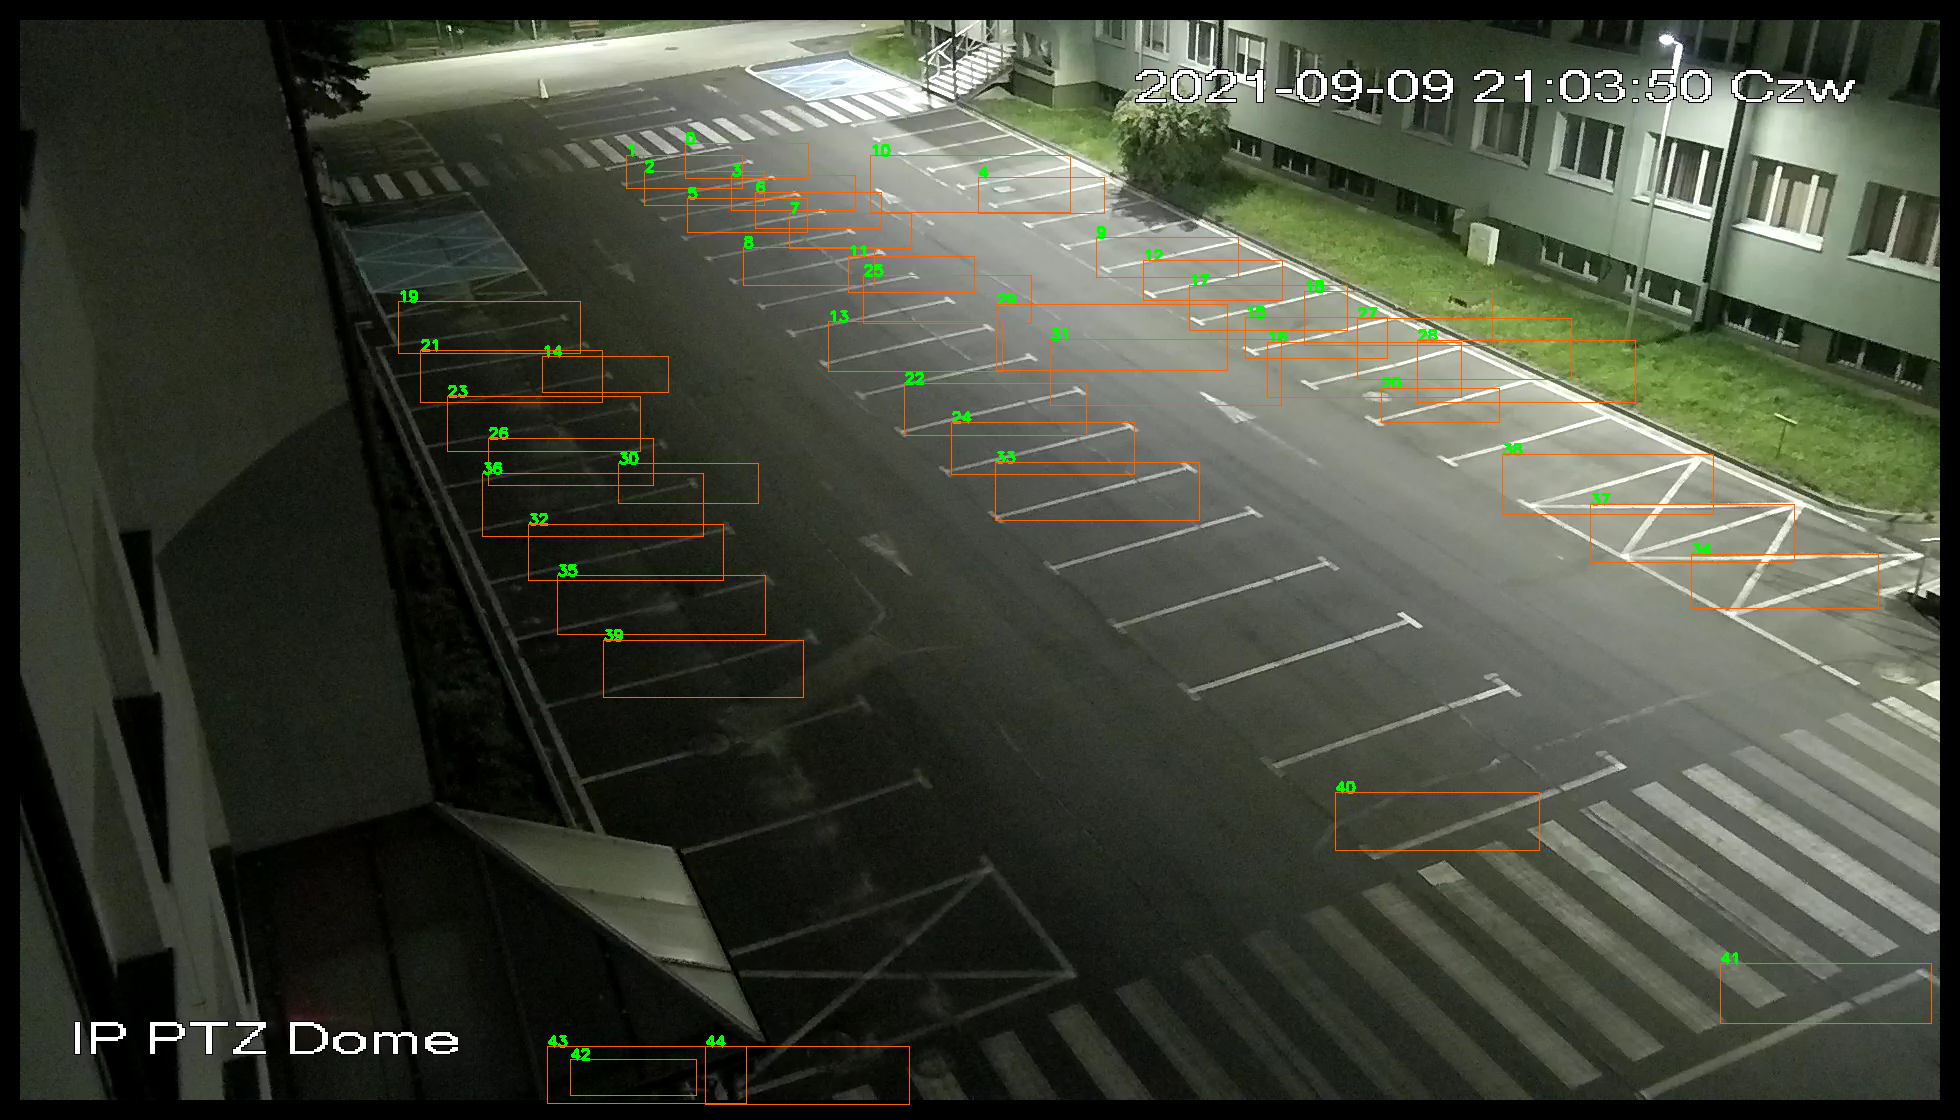

In [29]:
# load the image and convert it to grayscale
image = cv2.imread('/content/file.bmp')
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# load the line detector and detect lines in the image
lineDetector = cv2.CascadeClassifier('/content/xml_data/cascade.xml') # link do xml'a

lineRegions = lineDetector.detectMultiScale(grayImage, scaleFactor=1.13, minNeighbors=3, minSize=(105, 27),  maxSize=(250, 80), flags=cv2.CASCADE_SCALE_IMAGE)

print(f"Total {len(lineRegions)} line(s) found on the image")

for i, (x, y, w, h) in enumerate(lineRegions):
  cv2.putText(image, str(i), (x, y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
              fontScale=.5, color=(0, 255, 0), thickness=2)
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 100, 255), 1)


cv2_imshow(image)

Index: 0; percentage: 
  0.1389


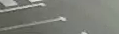

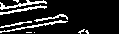

------------------------------
Index: 1; percentage: 
  0.12198


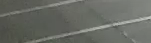

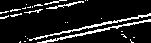

------------------------------
Index: 2; percentage: 
  0.14537


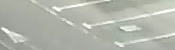

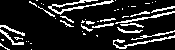

------------------------------
Index: 3; percentage: 
  0.1049


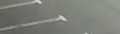

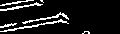

------------------------------
Index: 4; percentage: 
  0.16671


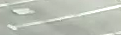

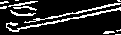

------------------------------
Index: 5; percentage: 
  0.108


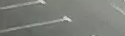

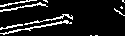

------------------------------
Index: 6; percentage: 
  0.0993


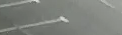

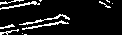

------------------------------
Index: 7; percentage: 
  0.09834


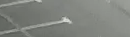

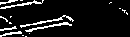

------------------------------
Index: 8; percentage: 
  0.12384


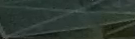

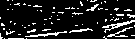

------------------------------
Index: 9; percentage: 
  0.13237


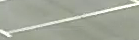

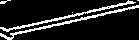

------------------------------
Index: 10; percentage: 
  0.13174


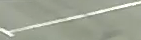

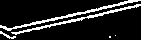

------------------------------
Index: 11; percentage: 
  0.03487


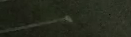

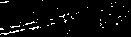

------------------------------
Index: 12; percentage: 
  0.06654


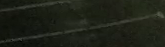

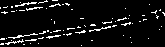

------------------------------
Index: 13; percentage: 
  0.10403


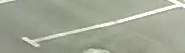

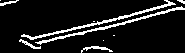

------------------------------
Index: 14; percentage: 
  0.02778


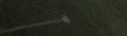

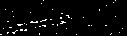

------------------------------
Index: 15; percentage: 
  0.21959


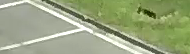

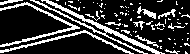

------------------------------
Index: 16; percentage: 
  0.06488


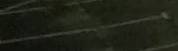

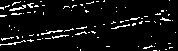

------------------------------
Index: 17; percentage: 
  0.11238


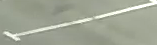

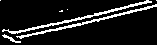

------------------------------
Index: 18; percentage: 
  0.05045


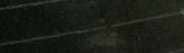

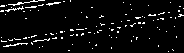

------------------------------
Index: 19; percentage: 
  0.03409


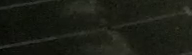

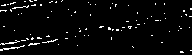

------------------------------
Index: 20; percentage: 
  0.09516


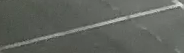

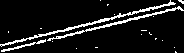

------------------------------
Index: 21; percentage: 
  0.02456


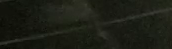

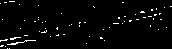

------------------------------
Index: 22; percentage: 
  0.02854


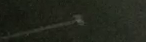

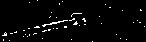

------------------------------
Index: 23; percentage: 
  0.19733


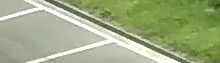

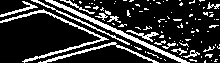

------------------------------
Index: 24; percentage: 
  0.03327


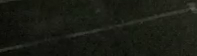

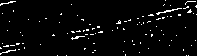

------------------------------
Index: 25; percentage: 
  0.08771


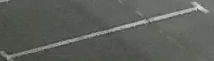

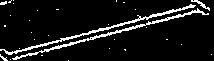

------------------------------
Index: 26; percentage: 
  0.19818


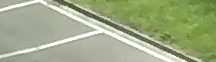

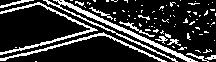

------------------------------
Index: 27; percentage: 
  0.03623


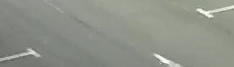

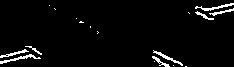

------------------------------
Index: 28; percentage: 
  0.17424


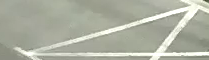

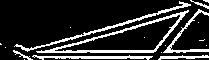

------------------------------
Index: 29; percentage: 
  0.04002


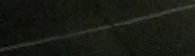

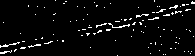

------------------------------
Index: 30; percentage: 
  0.03048


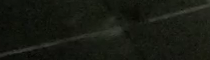

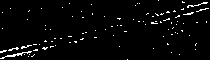

------------------------------
Index: 31; percentage: 
  0.03057


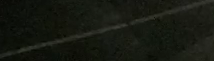

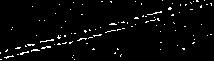

------------------------------
Index: 32; percentage: 
  0.06271


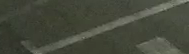

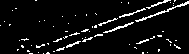

------------------------------
Index: 33; percentage: 
  0.02431


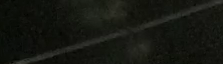

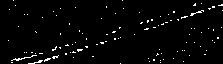

------------------------------
Index: 34; percentage: 
  0.05954


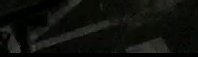

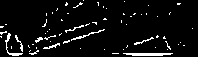

------------------------------
Index: 35; percentage: 
  0.02815


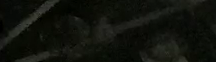

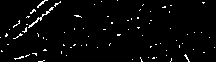

------------------------------


In [28]:
# https://www.pyimagesearch.com/2021/05/12/adaptive-thresholding-with-opencv-cv2-adaptivethreshold/

image = cv2.imread('/content/file.bmp')
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

lineDetector = cv2.CascadeClassifier('/content/xml_data/cascade.xml') # link do xml'a

lineRegions = lineDetector.detectMultiScale(grayImage, 
                                            scaleFactor=1.03, 
                                            minNeighbors=13, 
                                            minSize=(105, 27), 
                                            maxSize=(250, 80), 
                                            flags=cv2.CASCADE_SCALE_IMAGE)

for idx, (x, y, w, h) in enumerate(lineRegions):
  gray = grayImage[y: y + h, x: x + w]
  adaptiveThreshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                            cv2.THRESH_BINARY_INV, 7, 7)
  unique, counts = np.unique(adaptiveThreshold, return_counts=True)
  dictOfUniqueElements = dict(zip(unique, counts))

  print(f'''Index: {idx}; percentage: 
  {round(dictOfUniqueElements[255] / (
      dictOfUniqueElements[0] + dictOfUniqueElements[255]), 5)}''')
  
  cv2_imshow(image[y: y + h, x: x + w])
  cv2_imshow(adaptiveThreshold)
  print('-' * 30)